In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
import  os
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from utils import Optuna_for_LGB
from preprocess import convert_notation, region_encoding, region_grouping, region_additional_group
PATH = '../data/'
TRAIN = True

In [2]:
train_df = pd.read_csv(PATH + 'train.csv')
test_df = pd.read_csv(PATH + 'test.csv')
train_df = convert_notation(train_df)
test_df = convert_notation(test_df)
train_df, test_df, le = region_encoding(train_df, test_df)
columns = list(test_df.columns)
columns.remove('index')
columns.remove('region')
train_df, test_df = region_grouping(train_df, test_df, columns, diff=True, drop=True)
train_df, test_df = region_additional_group(train_df, test_df, columns, drop=True)
print(train_df.shape, test_df.shape)
train_df.head()

(4043, 68) (4046, 67)


,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,speechiness_region_mean_div_kurtosis,speechiness_region_mean_div_skew,instrumentalness_region_mean_div_kurtosis,instrumentalness_region_mean_div_skew,tempo_region_mean_div_kurtosis,tempo_region_mean_div_skew,tempo_min_region_mean_div_kurtosis,tempo_min_region_mean_div_skew,tempo_max_region_mean_div_kurtosis,tempo_max_region_mean_div_skew
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0.041109,0.112748,0.126031,0.271669,-7.081689,-23.496356,-663.568056,24.372896,-21.499918,-188.561463
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,NaN,NaN,-0.006443,-0.022655,2.213210,4.778752,136.935692,67.479421,-65.069600,758.945407
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,NaN,NaN,-0.002820,-0.009792,22.089902,104.713180,-78.514916,-61.786142,99.824071,-349.117895
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0.003414,0.014053,-0.004110,-0.013158,12.970919,44.487261,-692.334480,108.132148,-77.568505,-2012.028932
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,NaN,NaN,0.001539,0.004443,1.655753,18.363618,-38.405528,-25.713987,22.080413,-666.828288


In [3]:
train_df.columns

Index(['index', 'genre', 'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo', 'region', 'tempo_min',
       'tempo_max', 'popularity_region_mean_diff',
       'popularity_region_mean_diff_region_std_diff',
       'duration_ms_region_mean_diff',
       'duration_ms_region_mean_diff_region_std_diff',
       'acousticness_region_mean_diff',
       'acousticness_region_mean_diff_region_std_diff',
       'positiveness_region_mean_diff',
       'positiveness_region_mean_diff_region_std_diff',
       'danceability_region_mean_diff',
       'danceability_region_mean_diff_region_std_diff',
       'loudness_region_mean_diff',
       'loudness_region_mean_diff_region_std_diff', 'energy_region_mean_diff',
       'energy_region_mean_diff_region_std_diff', 'liveness_region_mean_diff',
       'liveness_region_mean_diff_region_std_diff',
       'speechiness_region_mean_diff',
       'spe

In [4]:
objective_args = {
    'num_leaves': {
        'type': 'int',
        'suggest_args': {
            'name': 'num_leaves',
            'low': 2,
            'high': 128,
        }
    },
    'max_depth': {
        'type': 'int',
        'suggest_args': {
            'name': 'max_depth',
            'low': 3,
            'high': 8,
        }
    },
    'min_data_in_leaf': {
        'type': 'int',
        'suggest_args': {
            'name': 'min_data_in_leaf',
            'low': 5,
            'high': 90,
        }
    },
    'n_estimators': {
        'type': 'int',
        'suggest_args': {
            'name': 'n_estimators',
            'low': 100,
            'high': 1000,
        }
    },
    'learning_rate': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'learning_rate',
            'low': 0.0001,
            'high': 0.1
        }
    },
    'bagging_fraction': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'bagging_fraction',
            'low': 0.0001,
            'high': 1.0,
        }
    },
    'feature_fraction': {
        'type': 'uniform',
        'suggest_args': {
            'name': 'feature_fraction',
            'low': 0.0001,
            'high': 1.0,
        }
    },
    'random_state': {
        'type': 'default',
        'value': 0
    },
    'objective': {
        'type': 'default',
        'value': 'cross_entropy'
    },
    'num_class': {
        'type': 'default',
        'value': 11
    },
    # 'class_weight': {
    #     'type': 'default',
    #     'value': class_weight
    # }
    
}
def evaluate_macroF1_lgb(true, pred):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred = pred.reshape(len(np.unique(true)), -1).argmax(axis=0)
    f1 = f1_score(true, pred, average='macro')
    return ('macroF1', f1, True) 

pipeline_args = {
    'fit_attr': 'fit',
    'pred_attr': 'predict',
    'fit_args': {
        # 'X': x_train,
        # 'y': y_train,
        # 'eval_set': (x_test, y_test),
        'eval_metric': evaluate_macroF1_lgb,
        'eval_names': ['validation'],
        'early_stopping_rounds': 50,
        'verbose': -1,
        # 'feature_name': columns
        'categorical_feature': ['region']
    },
    # 'pred_args': {'X': x_test},
    'metric': lambda true, pred: f1_score(true, pred, average='macro'),
    # 'metric_args': {'true': y_test},
    'model': lgb.LGBMClassifier,
}

In [5]:
%%capture
columns = list(test_df.columns)
columns.remove('index')
cv_num = 10
kf = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=0)
name = 'lgb_group_v2_select'
x, y = train_df[columns], train_df.genre
ofl = Optuna_for_LGB()
optuna.logging.disable_default_handler()
score = list()
for cv, (train_valid_idx, test_idx) in enumerate(kf.split(np.zeros(train_df.shape[0]), y)):
    x_tv, x_test = x.iloc[train_valid_idx], x.iloc[test_idx]
    y_tv, y_test = y.iloc[train_valid_idx], y.iloc[test_idx]
    cv_score = list()
    for valid_cv, (train_idx, valid_idx) in enumerate(kf.split(np.zeros(x_tv.shape[0]), y_tv)):
        x_train, x_valid = x_tv.iloc[train_idx], x_tv.iloc[valid_idx]
        y_train, y_valid = y_tv.iloc[train_idx], y_tv.iloc[valid_idx]
        x_train = x_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        # x_train = region_fix(x_train, y_train, thre_count, le.transform(['unknown'])[0])
        pipeline_args['fit_args']['X'] = x_train
        pipeline_args['fit_args']['y'] = y_train
        pipeline_args['fit_args']['eval_set'] = (x_valid, y_valid)
        pipeline_args['fit_args']['feature_name'] = columns
        pipeline_args['pred_args'] = {'X': x_valid}
        pipeline_args['metric_args'] = {'true': y_valid}
        if TRAIN:
            params = ofl.parameter_tuning(pipeline_args, objective_args, 1000, -1, 0)

            best_iteration = params.pop('best_iteration_')
            model = lgb.LGBMClassifier(**params)
            model.fit(**pipeline_args['fit_args'])
            y_pred = model.predict_proba(x_test, model.best_iteration_)
            model.booster_.save_model('../model/{0}_{1}_{2}.txt'.format(name, cv, valid_cv))
        else:
            model = lgb.Booster(model_file='../model/{0}_{1}_{2}.txt'.format(name, cv, valid_cv))
            y_pred = model.predict(x_test).astype(np.float64)

        cv_score.append(f1_score(y_test, np.argmax(y_pred, axis=1), average='macro'))
    score.append(cv_score)

In [6]:
score, np.mean(score, axis=1), np.mean(score)

([[0.5814158484733677,
   0.5897741841455718,
   0.5966469712978908,
   0.5766015247117484,
   0.6140807219500277,
   0.5630233653674088,
   0.6190776489727481,
   0.562142023115184,
   0.6252973821372972,
   0.5377135823893588],
  [0.6563316266527912,
   0.6423433024504487,
   0.6253437431341217,
   0.6351446135906188,
   0.6387991287257564,
   0.6014977287922466,
   0.5858399830117026,
   0.6305177991044855,
   0.6335865102901743,
   0.6076845948757477],
  [0.5116196200248986,
   0.5027131173821391,
   0.5076939785575381,
   0.5124641099442263,
   0.5548715746181323,
   0.5308752197538913,
   0.5703946995081138,
   0.4801817853210211,
   0.5647664677646268,
   0.546351036035015],
  [0.5974377489424474,
   0.59763033890578,
   0.5675964824319237,
   0.5920875896640054,
   0.6071396688178083,
   0.5813128717179065,
   0.5382797981128885,
   0.6112406363592541,
   0.5804224988927528,
   0.5452763640137467],
  [0.5609760792452761,
   0.5763183166953788,
   0.6242876100645522,
   0.642344

In [7]:
sub_df = pd.read_csv(PATH + 'sample_submit.csv', header=None, names=['ID', 'Pred'])
prediction = np.zeros((test_df.shape[0], 11), dtype=np.float64)
x = test_df[columns]
for i in range(cv_num):
    for j in range(cv_num):
        model = lgb.Booster(model_file='../model/{0}_{1}_{2}.txt'.format(name, i, j))
        pred = model.predict(x).astype(np.float64)
        prediction += pred
prediction /= 100.0
sub_df.Pred = np.argmax(prediction, axis=1)
sub_df.head()

,ID,Pred
0,4046,8
1,4047,10
2,4048,10
3,4049,8
4,4050,8


<AxesSubplot:>

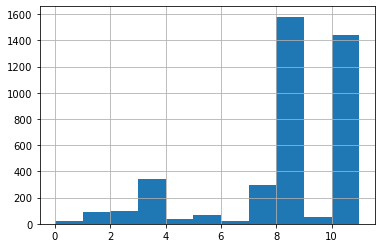

In [8]:
sub_df.Pred.hist(range=(0,11), bins=11)

In [9]:
sub_df.to_csv('../pred/{0}.csv'.format(name), index=None, header=None)